## Learning Objectives:

1. Learn fundamental TensorFlow concepts
2. Use LinearRegressor class in TensorFlow to predict median housing price
3. Evaluate the accuracy of the model using RMSE
4. Improve the accuracy of model by tuning its hyperparameter

## Setup

In [1]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

Load our dataset

In [2]:
california_housing_dataframe = pd.read_csv("https://dl.google.com/mlcc/mledu-datasets/california_housing_train.csv", sep=",")

Now we will do 2 things with the data:
1. Randomize the data
2. We will scale median_house_value to be in unit of thousands

In [3]:
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index)
)

california_housing_dataframe["median_house_value"] /= 1000.0

california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
7194,-118.3,34.1,52.0,1841.0,240.0,693.0,218.0,15.0,500.0
9561,-119.3,36.3,16.0,2624.0,527.0,1077.0,520.0,2.1,104.2
7613,-118.4,34.1,24.0,630.0,172.0,257.0,147.0,5.5,400.0
15617,-122.4,40.6,11.0,3896.0,886.0,1902.0,843.0,2.3,94.2
6648,-118.3,33.8,37.0,1212.0,304.0,1076.0,293.0,3.2,160.1
...,...,...,...,...,...,...,...,...,...
4349,-118.0,34.1,36.0,452.0,80.0,248.0,83.0,2.0,226.0
4765,-118.1,33.8,26.0,996.0,364.0,366.0,313.0,1.3,46.7
10746,-120.7,35.3,32.0,896.0,240.0,548.0,231.0,2.5,165.9
6506,-118.3,34.0,38.0,977.0,295.0,1073.0,292.0,1.0,86.4


## Examine the data

In [4]:
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


## Build the model

In this exercise, we will try to predict median_house_value, which will be our label. We'll use total_rooms as our input feature

To train our model, we will use LinearRegressor interface provided by TensorFlow Estimator API. 

In TensorFlow, we indicate the feature's data type using a construct called a *feature column*. Feature column only stores the description of the feature data, they do not contain the feature data itself.

In [5]:
# Define the input feature - total_rooms
my_feature = california_housing_dataframe[["total_rooms"]]

# Configure the numeric feature column for total_rooms.
feature_columns = [tf.feature_column.numeric_column("total_rooms")]

Note the shape of our total_rooms data is 1-D. This is default shape for numeric_column. Hence we're not specifying it.

Now, we need to define the target

In [8]:
# Define the label
targets = california_housing_dataframe["median_house_value"]

#### Configure the LinearRegresssor

Next we will configure the LinearRegressor model. We will use this model as GradientDescentOptimizer, which implements mini-batch Stochastic Gradient Desent (SGD). The learning_rate argument control the gradient step size.

*NOTE*: To be safe, we're also applying gradient clipping to our optimizer via clip_gradients_by_norm. It ensures that that magnitude of the gradients do not become too large during the training, which cause gradient desenct to fail.

In [7]:
# Use gradient desent as the optimizer to train the model
my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# Configure the LinearRegressor model with our feature columns and optimizer.
# Set the learning rate 0.0000001 for Gradient Desent.
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns = feature_columns,
    optimizer = my_optimizer
)

#### Define the Input Function

To import the California Housing dataset into the LinearRegressor, we need to define the input function, which instructs TensorFlow to preprocess the data, as well as how the batch, shuffle and repeat it during model training.

First we convert our pandas feature data into a numpy array. We can use the TensorFlow Dataset API to construct the dataset object from our data, and then break our data into batches of batch_size, to be repeated for specific number of epochs. (num_epochs). 

**Note**: When the num_epochs = None is passed to repeat(), the input data will be repeated infinitely.

Next, if shuffle is set to True, we will shuffle the data so that it's pass to the model randomly during training. The buffer_size argument specifies the size of the dataset from the shuffle will randomly sample.

Finally, our input function construct an iterator for the dataset and returns next batch of data to the LinearRegressor

In [9]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """
    Train the LinearRegresssor model of one feature.
    
    Args:
        features: pandas Dataframe of features
        targets: pandas Dataframe of targets
        batch_size: Size of batches to be passed to the model
        shuffle: True or False. Whether to shuffle the data.
        num_epochs: Number of epochs should data be repeated. If set to None, it will repeat infinitely.
    Returns:
        Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into dict of np arrays.
    features = {key:np.array(value) for key, value in dict(features).items()}
    
    # Construct a dataset and configure batching/repeating
    ds = Dataset.from_tensor_slices((features, targets)) 
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data if specified
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

#### Train the model

We will now call train() on our linear_regressor to train the model. We'll wrap up my_input_fn in a lambda so that we can pass in my_feature and target as arguments, and to start, we'll train for 100 steps.

In [10]:
_ = linear_regressor.train(
    input_fn = lambda:my_input_fn(my_feature, targets),
    steps = 100
)

#### Evaluate the model

In [11]:
# Create an input function for prediction
# Note: since we're making only one prediction for each example, we don't need to
# repeat or shuffle the data here.
prediction_input_fn = lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)

# call predict() on Linear regressor to make predictions
predictions = linear_regressor.predict(input_fn=prediction_input_fn)

# Format prediction as numpy array so that we can calculate error metrics.
predictions = np.array([item['predictions'][0] for item in predictions])

# Print mean squared error and Root mean squared error.
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)

print("Mean squared error (on training data): %0.3f" %mean_squared_error)
print("Root mean squared error (on training data): %0.3f" %root_mean_squared_error)

Mean squared error (on training data): 56367.025
Root mean squared error (on training data): 237.417


Is this a good model? How would you judge how large the error is?

Mean Squared Error (MSE) can be hard to interpret, so we often look at Root mean squared error (RMSE) instead. A nice property of RMSE is that it can be interpreted on the same scale as the original targets.

Lets compare RMSE to the difference of min and max of the output targets.

In [12]:
min_house_value = california_housing_dataframe["median_house_value"].min()
max_house_value = california_housing_dataframe["median_house_value"].max()
min_max_difference = max_house_value - min_house_value

print("Min. Median House Value: %0.3f" % min_house_value)
print("Max. Median House Value: %0.3f" % max_house_value)
print("Difference between Min. and Max.: %0.3f" %min_max_difference)
print("Root Mean Squared Error: %0.3f" % root_mean_squared_error)

Min. Median House Value: 14.999
Max. Median House Value: 500.001
Difference between Min. and Max.: 485.002
Root Mean Squared Error: 237.417


Our error spans nearly half the range of the target values. Can we do better?

This is the question which nags every model developer. Let's develop some basic startegies to reduce the error.

The first thing we do is to look at how well our predictions match our targets, in terms of overall statistics.

In [13]:
calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)
calibration_data.describe()

,predictions,targets
count,17000.0,17000.0
mean,0.1,207.3
std,0.1,116.0
min,0.0,15.0
25%,0.1,119.4
50%,0.1,180.4
75%,0.2,265.0
max,1.9,500.0


Lets try to visualize in a plot using sample data

In [14]:
sample = california_housing_dataframe.sample(n=300)

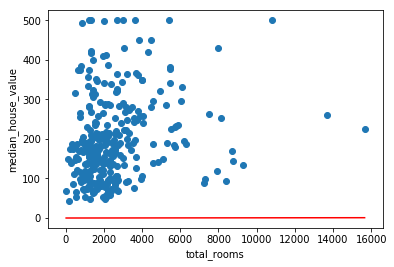

In [15]:
# Get the min and max total room values
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()

# Retrive the final weight and bias generated during training.
weight = linear_regressor.get_variable_value("linear/linear_model/total_rooms/weights")[0]
bias = linear_regressor.get_variable_value("linear/linear_model/bias_weights")

# Get the predicted median_house_values for the min and max total_rooms values.
y_0 = weight * x_0 + bias
y_1 = weight * x_1 + bias

# Plot our regression line
plt.plot([x_0, x_1], [y_0, y_1], c="r")

# Label the graph axes
plt.ylabel("median_house_value")
plt.xlabel("total_rooms")

# Plot the scatter plot from our data sample
plt.scatter(sample["total_rooms"], sample["median_house_value"])

# Display graph
plt.show()

## Tweak the Model Hyperparameter

Lets put all our code in a single cell.

In [19]:
def train_model_new(learning_rate, steps, batch_size, input_feature="total_rooms"):
  """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = california_housing_dataframe[[my_feature]]
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label]

  # Create feature columns.
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
  
  # Create input functions.
  training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
  prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Output a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

Training model...
RMSE (on training data):
  period 00 : 209.12
  period 01 : 186.29
  period 02 : 172.62
  period 03 : 167.19
  period 04 : 166.31
  period 05 : 166.53
  period 06 : 166.63
  period 07 : 166.88
  period 08 : 166.63
  period 09 : 166.63
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,138.8,207.3
std,114.5,116.0
min,0.1,15.0
25%,76.8,119.4
50%,111.7,180.4
75%,165.5,265.0
max,1991.9,500.0


Final RMSE (on training data): 166.63


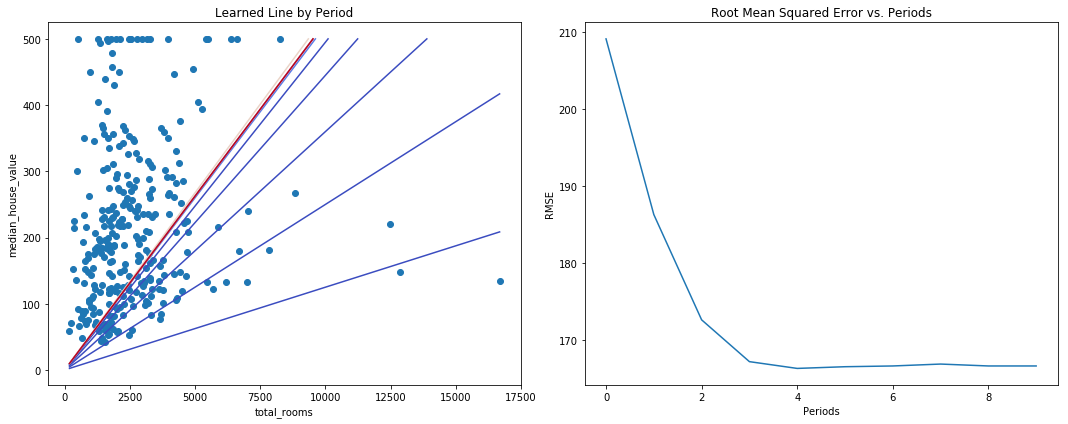

In [29]:
train_model_new(
    learning_rate = 0.00005,
    steps = 500,
    batch_size = 50
)

# train_model_new(
#     learning_rate=0.00002,
#     steps=500,
#     batch_size=5
# )

## Is there a standard heuristic for Model tuning?

The short answer is that the effects of different hyperparameters are data dependent. So there are no hard-and-fast rules and you need to test on your data.

Here are few thumb of rules which are helpfule:
* Training error should steadily decrease, steeply at first, and should eventually plateau as training converges.
* If training is not converged, try running it for longer
* If training error decreases too slowly, increasing the learning rate may help it decrease faster.
    - But sometimes the exact opposite happens if learning rate is too high.
* If the training error varies widely, try decreasing the learning rate.
    - Lower learning rate with large number of steps or larger batch size is often a good combination.
* Very small batch size also cause instability. First use values like 100 or 1000, and decrease until you see degradation.

## Try different feature

Training model...
RMSE (on training data):
  period 00 : 225.63
  period 01 : 214.62
  period 02 : 204.67
  period 03 : 196.42
  period 04 : 189.52
  period 05 : 184.46
  period 06 : 180.51
  period 07 : 178.67
  period 08 : 177.21
  period 09 : 176.16
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,117.2,207.3
std,94.1,116.0
min,0.2,15.0
25%,64.8,119.4
50%,95.7,180.4
75%,141.1,265.0
max,2925.9,500.0


Final RMSE (on training data): 176.16


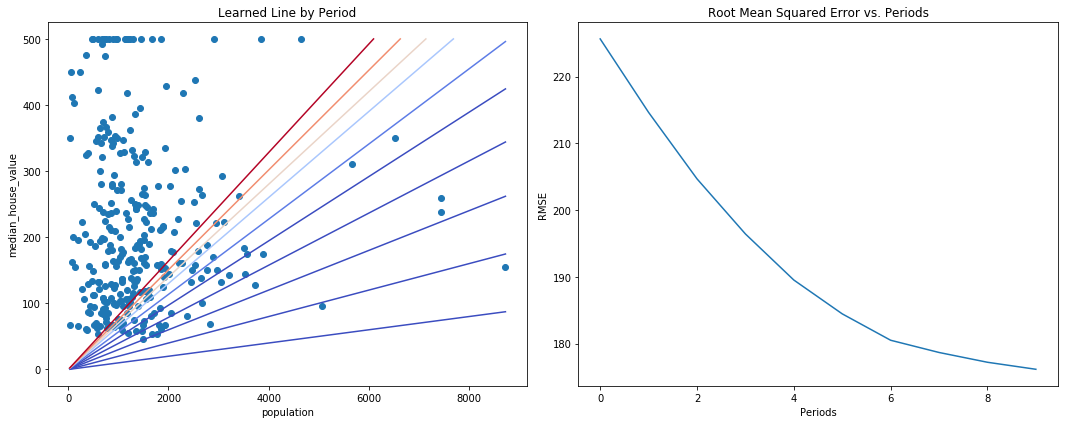

In [34]:
train_model_new(
    learning_rate=0.00002,
    steps=1000,
    batch_size=5,
    input_feature="population"
)